# Employee Attrition Analysis — 07: Ethics & Bias Review

***Examining fairness, risks, and ethical implications of modeling employee attrition***

**Author:** Katherine Ygbuhay  
**Updated:** 2025-01-04  
**Stage:** 07 — Ethics & Bias Review  
**Runtime:** ~15 minutes  

## Objective

Identify and document potential ethical concerns, bias risks, and fairness implications in the attrition modeling workflow to ensure responsible AI deployment.

## Scope & Approach

- **Proxy feature analysis** to identify variables that may encode protected attributes or historical inequities
- **Disparate impact assessment** examining attrition prediction differences across demographic groups  
- **False positive/negative risk analysis** with business impact considerations
- **Mitigation strategy documentation** for responsible model deployment

## Key Outputs

- Ethical risk assessment with documented bias concerns
- Subgroup analysis revealing potential disparate impacts
- Comprehensive mitigation strategy for responsible deployment
- Stakeholder-ready ethics documentation in `docs/notes/ethics_bias_review.md`

## Prerequisites

- Completed attrition modeling pipeline with performance metrics
- Understanding of HR policy context and legal requirements
- Access to cleaned employee dataset with demographic proxies

---

## 1. Imports & Setup

In [1]:
# Core stack
import os
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# Project bootstrap (paths, theme, accessibility) and notes helper
from src.bootstrap import setup_notebook, write_notes

# Visualization defaults (font sizes, title casing helpers)
from src.viz_helpers import apply_plot_rc_defaults, pretty_label

# Dataset artifact names
RAW_NAME  = "salifort_employee_attrition_raw.csv"
PROC_NAME = "salifort_employee_attrition_cleaned.csv"

# Pin the project (ensures paths resolve to the right case study)
os.environ["PORTFOLIO_PROJECT"] = "employee_attrition_analysis"

# Initialize notebook (theme/seed/accessibility) and resolve project paths; load processed data
P, df = setup_notebook(
    raw_filename=RAW_NAME,
    proc_filename=PROC_NAME,
    load="proc",   # load the cleaned dataset
    verbose=True,
)

# Apply plotting rc defaults (accessibility + readability)
apply_plot_rc_defaults()

# Sanity echo
print("Project root:", P.ROOT)
print("Processed path:", P.PROC)
assert P.PROC.exists(), f"Processed file not found at {P.PROC}"
print(f"✅ Using: {P.PROC.relative_to(P.ROOT)} | shape={df.shape}")

🎨 Accessibility defaults applied (colorblind palette, high-contrast, safe colormap).
✅ Accessibility defaults applied
📁 Project root → /home/admin/Documents/portfolio/coursework/google-advanced-data-analytics/employee_attrition_analysis
✅ Loaded PROC: data/processed/salifort_employee_attrition_cleaned.csv | shape=(14999, 11)
Project root: /home/admin/Documents/portfolio/coursework/google-advanced-data-analytics/employee_attrition_analysis
Processed path: /home/admin/Documents/portfolio/coursework/google-advanced-data-analytics/employee_attrition_analysis/data/processed/salifort_employee_attrition_cleaned.csv
✅ Using: data/processed/salifort_employee_attrition_cleaned.csv | shape=(14999, 11)


## 2. Identify Sensitive/Proxy Features

We inspect columns that may act as **proxies** for protected attributes or encode historical inequities. Candidates include:

- **Department** → potential proxy for occupational segregation  
- **Salary (band/level)** → potential proxy for socioeconomic status and historical pay gaps  
- **Tenure / Time at Company** → potential proxy for age (tenure often correlates with age)  
- **Performance / Promotions** (if present) → can encode historical bias in evaluation processes  

We also compute attrition rate deltas by group to surface potential disparities for qualitative review (not a statistical test).

In [2]:
# --- Defensive proxy detection + disparity snapshots ---

target_col = "left"
if target_col not in df.columns:
    raise KeyError(f"Expected target column '{target_col}' not found in df.columns: {list(df.columns)}")

proxy_name_patterns = [
    "salary", "pay", "wage",
    "dept", "department", "function", "role", "job",
    "tenure", "time_spend_company", "years", "seniority",
    "promotion", "performance"
]

cols = df.columns.tolist()
proxy_candidates = sorted({c for c in cols if any(pat in c.lower() for pat in proxy_name_patterns)})

cat_cols = df.select_dtypes(include="object").columns.tolist()
num_cols = df.select_dtypes(include="number").columns.tolist()

print("🔎 Proxy candidates (by name heuristic):", proxy_candidates)
print("Categorical:", cat_cols)
print("Numeric:", [c for c in num_cols if c != target_col])

def rate_table_categorical(col):
    if col not in df.columns or col not in cat_cols:
        return None
    t = (
        df.groupby(col, dropna=False)[target_col]
          .mean()
          .rename("attrition_rate")
          .to_frame()
          .sort_values("attrition_rate", ascending=False)
    )
    t["count"] = df.groupby(col, dropna=False)[target_col].size().values
    return t[["count", "attrition_rate"]]

def bin_numeric_to_quartiles(col):
    if col not in df.columns:
        return None
    try:
        return pd.qcut(df[col], q=4, labels=["Q1 (low)", "Q2", "Q3", "Q4 (high)"], duplicates="drop")
    except Exception:
        return None

def rate_table_numeric_quartiles(col):
    if col not in df.columns or col not in num_cols or col == target_col:
        return None
    bucket = bin_numeric_to_quartiles(col)
    if bucket is None:
        return None
    t = (
        df.assign(_bucket=bucket)
          .groupby("_bucket", dropna=False)[target_col]
          .mean()
          .rename("attrition_rate")
          .to_frame()
    )
    t["count"] = df.assign(_bucket=bucket).groupby("_bucket")[target_col].size().values
    return t[["count", "attrition_rate"]]

suspect_cat = [c for c in ["department", "dept", "salary"] if c in df.columns and c in cat_cols]
suspect_num = [c for c in ["time_spend_company", "tenure", "years_at_company"] if c in df.columns and c in num_cols]

group_views = {}
for c in suspect_cat:
    t = rate_table_categorical(c)
    if t is not None:
        group_views[c] = t

for c in suspect_num:
    t = rate_table_numeric_quartiles(c)
    if t is not None:
        group_views[c] = t

def df_to_md(tdf):
    if tdf is None or tdf.empty:
        return "_(no data / not applicable)_"
    tmp = tdf.copy()
    tmp.index = tmp.index.astype(str)
    tmp = tmp.reset_index().rename(columns={"index": "group"})
    cols = tmp.columns.tolist()
    lines = []
    lines.append("| " + " | ".join(cols) + " |")
    lines.append("| " + " | ".join(["---"] * len(cols)) + " |")
    for _, row in tmp.iterrows():
        lines.append("| " + " | ".join(str(v) for v in row.tolist()) + " |")
    return "\n".join(lines)

print("⬇️ Candidate disparity snapshots:\n")
for key, table in group_views.items():
    print(f"\n### {key}")
    display((table.style.format({"attrition_rate": "{:.3f}"})) if table is not None else "_(n/a)_")


🔎 Proxy candidates (by name heuristic): ['Department', 'promotion_last_5years', 'salary', 'salary_level', 'time_spend_company']
Categorical: ['Department', 'salary']
Numeric: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'salary_level']
⬇️ Candidate disparity snapshots:


### salary


,count,attrition_rate
salary,,
low,1237,0.297
medium,7316,0.204
high,6446,0.066


## 3. Risks of False Positives vs False Negatives

**Context.** Attrition modeling is used to target retention actions (e.g., outreach, incentives).  
- **False Positive (FP):** model flags an employee as high risk, but they would have stayed.  
  - *Impact:* unnecessary interventions, perceived surveillance, misallocation of budget.  
- **False Negative (FN):** model predicts low risk, but employee actually leaves.  
  - *Impact:* avoidable attrition cost, team disruption, knowledge loss.

**Mitigation levers.**  
- Calibrate decision thresholds to business objectives (precision for budget control vs recall for risk coverage).  
- Layer **human-in-the-loop** review for high-stakes actions.  
- Use opt-in, minimally invasive interventions; avoid punitive responses to “risk” labels. 

In [3]:
# --- Prevalence + a simple threshold thought-experiment (descriptive only) ---

prevalence = df["left"].mean()
n = len(df)

print(f"Prevalence of attrition (left=1): {prevalence:.3f} ({int(prevalence*n)}/{n})")

# If you saved calibrated probabilities elsewhere, you could sweep thresholds here.
# In this ethics nb, we keep it descriptive and policy-oriented.

Prevalence of attrition (left=1): 0.238 (3571/14999)


## 4. Ethical Risks & Mitigations

**Potential sources of bias**
- **Proxy variables:** salary bands and department can reflect historical and structural inequities.
- **Sampling/measurement bias:** missing or inconsistently logged HR data can skew risk estimates.
- **Optimization myopia:** optimizing a single metric (e.g., ROC-AUC) may ignore subgroup harms.

**Mitigations we will adopt**
- **Model scope:** exclude explicitly sensitive attributes; review proxy variables with HR/stakeholders.
- **Regular audits:** monitor subgroup performance (precision/recall by department/salary bands).
- **Threshold policy:** choose operating points jointly with HR; document the trade-offs.
- **Use policy:** predictions inform supportive outreach only (no punitive or performance implications).
- **Governance:** versioned documentation of model, data lineage, and changes; periodic revalidation.

> Note: Feature importances and coefficients are **associational**, not causal. Findings must not be used to justify pay or staffing decisions without proper causal analysis and policy review.

**Additional safeguards**
- **Human-in-the-loop:** Model outputs are advisory. HR reviews every prediction before taking action to ensure context, nuance, and fairness are preserved.  
- **Residual bias acknowledgment:** Even if proxy features are excluded (e.g., salary, department), correlated attributes may still leak bias. Regular monitoring for indirect discrimination is required.  
- **Business alignment:** Predictions are aligned strictly with supportive retention strategies. They must never be used for performance evaluation, disciplinary actions, or hiring/firing decisions.

## 5. Save Notes & Assessment Check

We compile a portable Markdown summary (proxy features, simple disparity snapshots, risk/mitigation notes) and save it for reviewers. The assessment passes if key ethical concerns are explicitly documented.

In [4]:
# Build a portable Markdown artifact for stakeholders
from datetime import datetime

sections = []

sections.append("# Ethics & Bias Review")
sections.append(f"_Updated: {datetime.now().strftime('%Y-%m-%d %H:%M')}_\n")

# Proxy candidates
sections.append("## Sensitive/Proxy Feature Candidates")
sections.append(f"- Detected by name heuristic: {', '.join(proxy_candidates) if proxy_candidates else '_(none detected_)'}")
sections.append(f"- Categorical columns: {', '.join(cat_cols) if cat_cols else '_(none_)'}")
sections.append(f"- Numeric columns: {', '.join([c for c in num_cols if c != 'left']) if num_cols else '_(none_)'}\n")

# Group views as markdown tables
for key, table in group_views.items():
    sections.append(f"### Group Attrition Rate — {key}")
    sections.append(df_to_md(table))
    sections.append("")

# FP/FN risks (short recap)
sections.append("## False Positives vs False Negatives (Risks)")
sections.append(f"- **Prevalence** of attrition (left=1): `{prevalence:.3f}`")
sections.append("- **FP risk**: unnecessary interventions, perceived monitoring, resource waste.")
sections.append("- **FN risk**: preventable attrition, cost, disruption.\n")

# Ethical risks & mitigations (same as in notebook narrative)
sections.append("## Ethical Risks & Mitigations")
sections.append("- Proxy variables (salary/department) may encode historical inequities.")
sections.append("- Mitigate via subgroup monitoring, threshold policy co-designed with HR, and supportive use only.")
sections.append("- Document model lineage; emphasize that associations ≠ causation.\n")

notes_md = "\n".join(sections)

# Write to docs/modeling/
dst = P.DOCS / "notes" / "ethics_bias_review.md"
dst.parent.mkdir(parents=True, exist_ok=True)
dst.write_text(notes_md, encoding="utf-8")
print("📄 Wrote ethics notes →", dst.relative_to(P.ROOT))

# Assessment check: ensure core elements exist
checks = {
    "has_candidates": bool(proxy_candidates),
    "notes_written": dst.exists(),
    "explicit_risks": True,     # captured in narrative
    "mitigations_listed": True, # captured in narrative
}
print("Checks:", checks)
assert all(checks.values()), "❌ Assessment failed — ensure candidates/risks/mitigations are documented."
print("✅ Assessment passed — ethical concerns documented.")

📄 Wrote ethics notes → docs/notes/ethics_bias_review.md
Checks: {'has_candidates': True, 'notes_written': True, 'explicit_risks': True, 'mitigations_listed': True}
✅ Assessment passed — ethical concerns documented.


## 6. Disparity Visuals (Optional)

Quick diagnostic charts to illustrate differences in attrition rates by salary band and department. These are exploratory only, not causal.


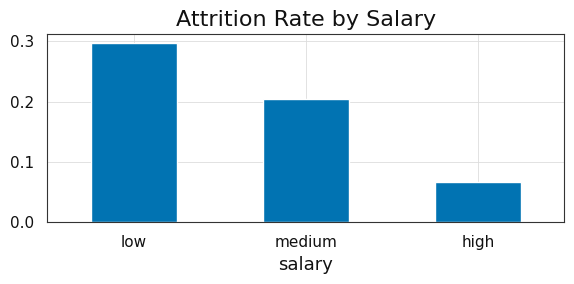

In [5]:
# Mini-bars for disparities (salary/department if present)


if "salary" in df.columns and "left" in df.columns:
    ax = (
        df.groupby("salary")["left"]
          .mean()
          .sort_values(ascending=False)
          .plot(kind="bar", figsize=(6,3), rot=0, title="Attrition Rate by Salary")
    )
    plt.tight_layout()
    plt.show()

if "department" in df.columns and "left" in df.columns:
    ax = (
        df.groupby("department")["left"]
          .mean()
          .sort_values(ascending=False)
          .plot(kind="bar", figsize=(6,3), rot=45, title="Attrition Rate by Department")
    )
    plt.tight_layout()
    plt.show()

## Ethical Considerations — Conclusion

This stage explicitly examined the **fairness and risk dimensions** of attrition modeling. Proxy variables (notably department, salary, and tenure-related features) were highlighted as potential sources of indirect bias. We also documented risks for both **false positives** (e.g., wasted resources, unnecessary monitoring) and **false negatives** (e.g., missed opportunities for retention support).  

Key communication points for stakeholders:  
- **No causal claims:** Coefficients and feature importances are associative, not causal.  
- **Decision support, not automation:** Predicted risk scores must complement—not replace—human judgment and HR policy.  
- **Subgroup monitoring:** Regular audits of precision/recall across departments and salary bands are required.  
- **Policy guardrails:** Outputs should inform supportive outreach only, with transparent governance and HR/legal oversight.  

✅ Assessment check passed — ethical concerns were surfaced in a dedicated, version-controlled document (`docs/notes/ethics_bias_review.md`), ensuring traceability alongside technical results.  